# LinkedIn Job Salary Prediction - Comprehensive ML Model
========================================================================================

This comprehensive model implements multiple ML algorithms to predict job salaries
from LinkedIn job postings data with extensive comparative analysis.
*Requirements:*
- pandas, numpy, scikit-learn, tensorflow, keras, matplotlib, xgboost

In [ ]:
# --- Import Libs ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Comprehensive Class

In [2]:
class LinkedInSalaryPredictor:
    """
    Comprehensive salary prediction model with multiple algorithms
    Updated for actual LinkedIn dataset structure
    """
    def __init__(self):
        self.models = {}
        self.results = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_names = []
        
    def load_and_preprocess_data(self, x):
        df = x
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nDataset Overview:")
        print(f"Total job postings: {len(df):,}")
        print(f"Unique companies: {df['company_name'].nunique():,}")
        print(f"Unique job titles: {df['title'].nunique():,}")
        print(f"Date range: {df['listed_time'].min()} to {df['listed_time'].max()}")
        salary_columns = ['max_salary', 'med_salary', 'min_salary', 'normalized_salary']
        print(f"\nSalary Data Analysis:")
        for col in salary_columns:
            if col in df.columns:
                non_null_count = df[col].notna().sum()
                print(f"  {col}: {non_null_count:,} non-null values ({non_null_count/len(df)*100:.1f}%)")
        
        # Choose target salary column
        target_salary = self._select_target_salary(df)
        df['target_salary'] = target_salary
        # Clean and filter data
        df = self._clean_salary_data(df)
        # Feature engineering
        df = self._feature_engineering(df)
        
        return df
    
    def _select_target_salary(self, df):
        salary_priority = ['normalized_salary', 'med_salary', 'max_salary', 'min_salary']
        for col in salary_priority:
            if col in df.columns:
                non_null_count = df[col].notna().sum()
                if non_null_count > 1000:  # At least 1000 valid salaries
                    print(f"Using '{col}' as target salary variable ({non_null_count:,} non-null values)")
                    return df[col].copy()  # Use .copy() to avoid warnings
        
        # Start with Series of NaNs
        target = pd.Series(index=df.index, dtype=float, name='target_salary')
        # Fill with available salary data in priority order
        for col in salary_priority:
            if col in df.columns:
                mask = target.isna() & df[col].notna()
                target[mask] = df[col][mask]
                filled_count = mask.sum()
                if filled_count > 0:
                    print(f"  - Filled {filled_count:,} values from '{col}'")
        
        if target.notna().sum() < 100:
            if 'min_salary' in df.columns and 'max_salary' in df.columns:
                both_available = df['min_salary'].notna() & df['max_salary'].notna()
                if both_available.sum() > 100:
                    avg_salary = (df['min_salary'] + df['max_salary']) / 2
                    mask = target.isna() & both_available
                    target[mask] = avg_salary[mask]
                    print(f"  - Created {mask.sum():,} values from min/max average")
        
        valid_count = target.notna().sum()
        print(f"Final target salary has {valid_count:,} valid values")
        
        if valid_count < 100:
            print("Warning: Very few valid salary values found!")
        return target
    
    def _clean_salary_data(self, df):
        # Remove rows with missing salary
        initial_count = len(df)
        df = df.dropna(subset=['target_salary'])
        print(f"Removed {initial_count - len(df):,} rows with missing salary")
        # Convert to numeric if needed
        df['target_salary'] = pd.to_numeric(df['target_salary'], errors='coerce')
        df = df.dropna(subset=['target_salary'])
        # Remove unrealistic salaries
        # Keep salaries between $15,000 and $1,000,000
        df = df[(df['target_salary'] >= 15000) & (df['target_salary'] <= 1000000)]
        # Remove outliers using IQR method
        Q1 = df['target_salary'].quantile(0.25)
        Q3 = df['target_salary'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (df['target_salary'] >= max(lower_bound, 20000)) & (df['target_salary'] <= min(upper_bound, 800000))
        df = df[outlier_mask]
        print(f"Final dataset: {len(df):,} records")
        print(f"Salary range: ${df['target_salary'].min():,.0f} - ${df['target_salary'].max():,.0f}")
        print(f"Mean salary: ${df['target_salary'].mean():,.0f}")
        print(f"Median salary: ${df['target_salary'].median():,.0f}")
        return df
    
    def _feature_engineering(self, df):
        # Job Title Features (from 'title' column)
        if 'title' in df.columns:
            df['title_length'] = df['title'].str.len().fillna(0)
            df['is_senior'] = df['title'].str.contains('Senior|Sr\.|Principal|Lead', case=False, na=False).astype(int)
            df['is_manager'] = df['title'].str.contains('Manager|Director|Head|VP|Chief', case=False, na=False).astype(int)
            df['is_engineer'] = df['title'].str.contains('Engineer|Developer|Programmer', case=False, na=False).astype(int)
            df['is_analyst'] = df['title'].str.contains('Analyst|Analysis', case=False, na=False).astype(int)
            df['is_scientist'] = df['title'].str.contains('Scientist|Research', case=False, na=False).astype(int)
        
        # Company Features (from 'company_name' column)
        if 'company_name' in df.columns:
            # Company posting frequency (proxy for company size)
            company_counts = df['company_name'].value_counts()
            df['company_posting_count'] = df['company_name'].map(company_counts).fillna(0)
            
            # Major tech companies
            big_tech = ['Google', 'Microsoft', 'Amazon', 'Apple', 'Facebook', 'Meta', 'Netflix', 'Tesla']
            df['is_big_tech'] = df['company_name'].str.contains('|'.join(big_tech), case=False, na=False).astype(int)
        
        # Location Features (from 'location' column)
        if 'location' in df.columns:
            # High-salary cities
            high_salary_cities = ['San Francisco', 'New York', 'Seattle', 'Boston', 'San Jose', 'Austin', 'Washington']
            df['is_high_salary_city'] = df['location'].str.contains('|'.join(high_salary_cities), case=False, na=False).astype(int)
            
            # Extract state information
            df['has_state_info'] = df['location'].str.contains(r',\s*[A-Z]{2}', na=False).astype(int)
        
        # Experience Level Features (from 'formatted_experience_level' column)
        if 'formatted_experience_level' in df.columns:
            df['exp_level_entry'] = df['formatted_experience_level'].str.contains('Entry|Internship', case=False, na=False).astype(int)
            df['exp_level_mid'] = df['formatted_experience_level'].str.contains('Mid|Associate', case=False, na=False).astype(int)
            df['exp_level_senior'] = df['formatted_experience_level'].str.contains('Senior|Executive', case=False, na=False).astype(int)
        
        # Work Type Features (from 'formatted_work_type' and 'work_type' columns)
        if 'formatted_work_type' in df.columns:
            df['is_full_time'] = df['formatted_work_type'].str.contains('Full-time', case=False, na=False).astype(int)
            df['is_part_time'] = df['formatted_work_type'].str.contains('Part-time', case=False, na=False).astype(int)
            df['is_contract'] = df['formatted_work_type'].str.contains('Contract', case=False, na=False).astype(int)
        
        # Remote Work Features (from 'remote_allowed' column)
        if 'remote_allowed' in df.columns:
            df['remote_work'] = df['remote_allowed'].astype(int)
                
        # Description Features (from 'description' column)
        if 'description' in df.columns:
            df['description_length'] = df['description'].str.len().fillna(0)
            # Technology skills
            df['mentions_python'] = df['description'].str.contains('Python', case=False, na=False).astype(int)
            df['mentions_sql'] = df['description'].str.contains('SQL', case=False, na=False).astype(int)
            df['mentions_java'] = df['description'].str.contains('Java', case=False, na=False).astype(int)
            df['mentions_aws'] = df['description'].str.contains('AWS|Amazon Web Services', case=False, na=False).astype(int)
            df['mentions_machine_learning'] = df['description'].str.contains('Machine Learning|ML|AI|Artificial Intelligence', case=False, na=False).astype(int)
            df['mentions_docker'] = df['description'].str.contains('Docker|Kubernetes', case=False, na=False).astype(int)
            df['mentions_react'] = df['description'].str.contains('React|Angular|Vue', case=False, na=False).astype(int)
            # Education requirements
            df['requires_degree'] = df['description'].str.contains('Bachelor|Master|PhD|Degree', case=False, na=False).astype(int)
            df['requires_experience'] = df['description'].str.contains('years of experience|years experience', case=False, na=False).astype(int)
        # Skills Description Features (from 'skills_desc' column)
        if 'skills_desc' in df.columns:
            df['skills_desc_length'] = df['skills_desc'].str.len().fillna(0)
            df['has_skills_listed'] = (df['skills_desc'].notna() & (df['skills_desc'] != '')).astype(int)
        # Engagement Features (from 'views' and 'applies' columns)
        if 'views' in df.columns:
            df['view_count'] = pd.to_numeric(df['views'], errors='coerce').fillna(0)
            df['high_view_job'] = (df['view_count'] > df['view_count'].quantile(0.75)).astype(int)
        if 'applies' in df.columns:
            df['apply_count'] = pd.to_numeric(df['applies'], errors='coerce').fillna(0)
            df['popular_job'] = (df['apply_count'] > df['apply_count'].quantile(0.75)).astype(int)
        if 'listed_time' in df.columns:
            df['listed_time'] = pd.to_datetime(df['listed_time'], errors='coerce')
            df['listing_year'] = df['listed_time'].dt.year
            df['listing_month'] = df['listed_time'].dt.month
            df['listing_day_of_week'] = df['listed_time'].dt.dayofweek
            df['is_weekend_listing'] = (df['listing_day_of_week'] >= 5).astype(int)
        # Sponsored Job Features (from 'sponsored' column)
        if 'sponsored' in df.columns:
            df['is_sponsored'] = df['sponsored'].astype(int)
        return df
    
    def prepare_features(self, df):
        # Define target
        y = df['target_salary'].values
        # Select feature columns
        # Numerical features (engineered)
        numerical_features = [
            'title_length', 'company_posting_count', 'description_length', 'skills_desc_length',
            'view_count', 'apply_count', 'listing_year', 'listing_month', 'listing_day_of_week',
            'is_senior', 'is_manager', 'is_engineer', 'is_analyst', 'is_scientist',
            'is_big_tech', 'is_high_salary_city', 'has_state_info',
            'exp_level_entry', 'exp_level_mid', 'exp_level_senior',
            'is_full_time', 'is_part_time', 'is_contract', 'remote_work',
            'mentions_python', 'mentions_sql', 'mentions_java', 'mentions_aws',
            'mentions_machine_learning', 'mentions_docker', 'mentions_react',
            'requires_degree', 'requires_experience', 'has_skills_listed',
            'high_view_job', 'popular_job', 'is_weekend_listing', 'is_sponsored'
        ]
        
        # Filter only existing columns
        available_numerical = [col for col in numerical_features if col in df.columns]
        X_features = pd.DataFrame()
        # Add available numerical features
        for col in available_numerical:
            X_features[col] = df[col].fillna(0)
        
        # Categorical features to encode (top categories only)
        categorical_features = {
            'company_name': 20,  # Top 20 companies
            'formatted_experience_level': 10,  # All experience levels
            'formatted_work_type': 10,  # All work types
            'location': 15,  # Top 15 locations
        }
        
        # One-hot encode categorical features
        for col, max_categories in categorical_features.items():
            if col in df.columns and df[col].nunique() > 1:
                top_categories = df[col].value_counts().head(max_categories).index.tolist()
                df_col_processed = df[col].apply(lambda x: x if x in top_categories else 'Other')
                # One-hot encode
                dummies = pd.get_dummies(df_col_processed, prefix=col, dummy_na=True)
                X_features = pd.concat([X_features, dummies], axis=1)
        self.feature_names = X_features.columns.tolist()
        print(f"Total features created: {len(self.feature_names)}")
        print(f"Feature categories:")
        print(f"  - Engineered numerical features: {len(available_numerical)}")
        print(f"  - One-hot encoded categorical: {len(self.feature_names) - len(available_numerical)}")
        return X_features.values, y
    
    def initialize_models(self):
        self.models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Lasso Regression': Lasso(alpha=1.0),
            'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
            'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6),
            'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
            'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
            'Support Vector Regression': SVR(kernel='rbf', C=1.0),
        }
        
    def build_neural_network(self, input_dim):
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train_and_evaluate_models(self, X, y):
        print("Training and evaluating models...")
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=None
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        results = []
        
        # Train traditional ML models
        for name, model in self.models.items():
            print(f"Training {name}...")
            
            try:
                # Use scaled data for models that need it
                if name in ['Support Vector Regression', 'K-Nearest Neighbors', 'Ridge Regression', 
                           'Lasso Regression', 'Elastic Net']:
                    X_train_model = X_train_scaled
                    X_test_model = X_test_scaled
                else:
                    X_train_model = X_train
                    X_test_model = X_test
                
                # Train model
                model.fit(X_train_model, y_train)
                
                # Predictions
                y_pred = model.predict(X_test_model)
                
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, 
                                          scoring='neg_mean_squared_error')
                
                # Metrics
                mse = mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                rmse = np.sqrt(mse)
                
                results.append({
                    'Model': name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R²': r2,
                    'CV_RMSE': np.sqrt(-cv_scores.mean()),
                    'CV_STD': np.sqrt(cv_scores.std()),
                    'Predictions': y_pred
                })
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                results.append({
                    'Model': name,
                    'RMSE': np.inf,
                    'MAE': np.inf,
                    'R²': -np.inf,
                    'CV_RMSE': np.inf,
                    'CV_STD': np.inf,
                    'Predictions': np.full(len(y_test), y_test.mean())
                })
        
        try:
            nn_model = self.build_neural_network(X_train_scaled.shape[1])
            
            # Early stopping
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )
            
            # Train
            history = nn_model.fit(
                X_train_scaled, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Neural network predictions
            nn_pred = nn_model.predict(X_test_scaled).flatten()
            
            # Neural network metrics
            nn_mse = mean_squared_error(y_test, nn_pred)
            nn_mae = mean_absolute_error(y_test, nn_pred)
            nn_r2 = r2_score(y_test, nn_pred)
            nn_rmse = np.sqrt(nn_mse)
            
            results.append({
                'Model': 'Neural Network',
                'RMSE': nn_rmse,
                'MAE': nn_mae,
                'R²': nn_r2,
                'CV_RMSE': nn_rmse,
                'CV_STD': 0,
                'Predictions': nn_pred
            })
            
        except Exception as e:
            print(f"Error training Neural Network: {str(e)}")
            results.append({
                'Model': 'Neural Network',
                'RMSE': np.inf,
                'MAE': np.inf,
                'R²': -np.inf,
                'CV_RMSE': np.inf,
                'CV_STD': np.inf,
                'Predictions': np.full(len(y_test), y_test.mean())
            })
        
        # Store results
        self.results_df = pd.DataFrame(results)
        self.y_test = y_test
        self.X_test = X_test
        return results
    
    def hyperparameter_tuning(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
        tuning_results = {}
        try:
            # Random Forest tuning
            print("Tuning Random Forest...")
            rf_params = {
                'n_estimators': [50, 100, 200],
                'max_depth': [10, 15, 20],
                'min_samples_split': [2, 5, 10],
            }
            
            rf_grid = GridSearchCV(
                RandomForestRegressor(random_state=42),
                rf_params,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            rf_grid.fit(X_train, y_train)
            
            tuning_results['Random Forest'] = {
                'best_params': rf_grid.best_params_,
                'best_score': np.sqrt(-rf_grid.best_score_),
                'model': rf_grid.best_estimator_
            }
            
        except Exception as e:
            print(f"Error tuning Random Forest: {e}")
        
        try:
            # XGBoost tuning
            print("Tuning XGBoost...")
            xgb_params = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2],
            }
            
            xgb_grid = GridSearchCV(
                xgb.XGBRegressor(random_state=42),
                xgb_params,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            xgb_grid.fit(X_train, y_train)
            
            tuning_results['XGBoost'] = {
                'best_params': xgb_grid.best_params_,
                'best_score': np.sqrt(-xgb_grid.best_score_),
                'model': xgb_grid.best_estimator_
            }
            
        except Exception as e:
            print(f"Error tuning XGBoost: {e}")
        return tuning_results
    
    def feature_importance_analysis(self):
        # Get feature importance from tree-based models
        importance_results = {}
        for name, model in self.models.items():
            if hasattr(model, 'feature_importances_'):
                importance_results[name] = model.feature_importances_
        if importance_results:
            importance_df = pd.DataFrame(importance_results, index=self.feature_names)
            return importance_df
        
        return None
    
    def analyze_salary_insights(self, df):
        insights = {}
        
        # Company insights
        if 'company_name' in df.columns:
            company_stats = df.groupby('company_name')['target_salary'].agg(['mean', 'median', 'count']).round(0)
            company_stats = company_stats[company_stats['count'] >= 5].sort_values('mean', ascending=False)
            insights['top_paying_companies'] = company_stats.head(10)
        
        # Location insights
        if 'location' in df.columns:
            location_stats = df.groupby('location')['target_salary'].agg(['mean', 'median', 'count']).round(0)
            location_stats = location_stats[location_stats['count'] >= 10].sort_values('mean', ascending=False)
            insights['top_paying_locations'] = location_stats.head(10)
        
        # Experience level insights
        if 'formatted_experience_level' in df.columns:
            exp_stats = df.groupby('formatted_experience_level')['target_salary'].agg(['mean', 'median', 'count']).round(0)
            insights['salary_by_experience'] = exp_stats.sort_values('mean', ascending=False)
        
        # Work type insights
        if 'formatted_work_type' in df.columns:
            work_stats = df.groupby('formatted_work_type')['target_salary'].agg(['mean', 'median', 'count']).round(0)
            insights['salary_by_work_type'] = work_stats.sort_values('mean', ascending=False)
        
        # Remote work insights
        if 'remote_allowed' in df.columns:
            remote_stats = df.groupby('remote_allowed')['target_salary'].agg(['mean', 'median', 'count']).round(0)
            insights['remote_vs_onsite'] = remote_stats
        
        return insights
    
    def generate_comprehensive_report(self, df, results, tuning_results=None, importance_df=None):
        insights = self.analyze_salary_insights(df)
        self.create_visualizations(df, results, importance_df, insights)
        
        # Print detailed results
        print("\n" + "="*50)
        print("LINKEDIN JOB SALARY PREDICTION - COMPREHENSIVE RESULTS")
        print("="*50)
        print(f"\nDataset Summary:")
        print(f"- Total job postings analyzed: {len(df):,}")
        print(f"- Features engineered: {len(self.feature_names)}")
        print(f"- Salary range: ${df['target_salary'].min():,.0f} - ${df['target_salary'].max():,.0f}")
        print(f"- Mean salary: ${df['target_salary'].mean():,.0f}")
        print(f"- Median salary: ${df['target_salary'].median():,.0f}")
        print(f"- Standard deviation: ${df['target_salary'].std():,.0f}")
        print(f"\nModel Performance Ranking:")
        print("-" * 50)
        sorted_results = self.results_df.sort_values('R²', ascending=False)
        print(f"{'Rank':<4} {'Model':<20} {'R²':<8} {'RMSE':<12} {'MAE':<12} {'CV_RMSE':<10}")
        print("-" * 70)
        for i, (_, row) in enumerate(sorted_results.iterrows(), 1):
            if row['R²'] != -np.inf:  # Only show successful models
                print(f"{i:<4} {row['Model']:<20} {row['R²']:<8.4f} ${row['RMSE']:<11,.0f} ${row['MAE']:<11,.0f} ${row['CV_RMSE']:<9,.0f}")
        
        if tuning_results:
            print(f"\nHyperparameter Tuning Results:")
            print("-" * 50)
            for model_name, results in tuning_results.items():
                print(f"{model_name}:")
                print(f"  Best RMSE: ${results['best_score']:,.0f}")
                print(f"  Best params: {results['best_params']}")
        
        print(f"\nKey Model Insights:")
        best_model = sorted_results.iloc[0]
        print(f"- Best performing model: {best_model['Model']}")
        print(f"- Best R² score: {best_model['R²']:.4f}")
        print(f"- Average prediction error: ±${best_model['MAE']:,.0f}")
        print(f"- Model explains {best_model['R²']*100:.1f}% of salary variation")
        
        if importance_df is not None and len(importance_df) > 0:
            print(f"\n📈 Top 10 Most Important Features:")
            avg_importance = importance_df.mean(axis=1).sort_values(ascending=False)
            for i, (feature, importance) in enumerate(avg_importance.head(10).items(), 1):
                print(f"  {i:2d}. {feature:<30}: {importance:.4f}")
        
        # Business insights
        if insights:
            print(f"\nBusiness Insights:")
            
            if 'top_paying_companies' in insights:
                print(f"\nTop 5 Highest Paying Companies:")
                for company, stats in insights['top_paying_companies'].head().iterrows():
                    print(f"  {company:<25}: ${stats['mean']:>8,.0f} avg (${stats['median']:>8,.0f} median, {stats['count']:>3.0f} jobs)")
            
            if 'top_paying_locations' in insights:
                print(f"\nTop 5 Highest Paying Locations:")
                for location, stats in insights['top_paying_locations'].head().iterrows():
                    print(f"  {location:<25}: ${stats['mean']:>8,.0f} avg (${stats['median']:>8,.0f} median, {stats['count']:>3.0f} jobs)")
            
            if 'salary_by_experience' in insights:
                print(f"\nSalary by Experience Level:")
                for exp_level, stats in insights['salary_by_experience'].iterrows():
                    print(f"  {exp_level:<25}: ${stats['mean']:>8,.0f} avg (${stats['median']:>8,.0f} median, {stats['count']:>3.0f} jobs)")
            
            if 'remote_vs_onsite' in insights:
                print(f"\nRemote vs On-site Salary Comparison:")
                for remote_status, stats in insights['remote_vs_onsite'].iterrows():
                    status_label = "Remote Allowed" if remote_status else "On-site Only"
                    print(f"  {status_label:<25}: ${stats['mean']:>8,.0f} avg (${stats['median']:>8,.0f} median, {stats['count']:>3.0f} jobs)")
    
    def create_visualizations(self, df, results, importance_df=None, insights=None):
        plt.style.use('default')
        fig = plt.figure(figsize=(24, 18))
        
        # 1. Model Performance Comparison (R²)
        plt.subplot(3, 4, 1)
        valid_results = self.results_df[self.results_df['R²'] != -np.inf]
        models = valid_results['Model']
        r2_scores = valid_results['R²']
        
        bars = plt.bar(range(len(models)), r2_scores, color=plt.cm.RdYlGn([score for score in r2_scores]))
        plt.xlabel('Models')
        plt.ylabel('R² Score')
        plt.title('Model Performance Comparison (R²)')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, score in zip(bars, r2_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom', fontsize=8)
        
        # 2. RMSE Comparison
        plt.subplot(3, 4, 2)
        rmse_scores = valid_results['RMSE']
        bars = plt.bar(range(len(models)), rmse_scores, color=plt.cm.RdYlGn_r([score/rmse_scores.max() for score in rmse_scores]))
        plt.xlabel('Models')
        plt.ylabel('RMSE ($)')
        plt.title('Model Performance Comparison (RMSE)')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        # 3. Actual vs Predicted (Best Model)
        plt.subplot(3, 4, 3)
        best_idx = valid_results['R²'].idxmax()
        best_predictions = valid_results.loc[best_idx, 'Predictions']
        
        plt.scatter(self.y_test, best_predictions, alpha=0.6, s=20)
        min_val = min(self.y_test.min(), best_predictions.min())
        max_val = max(self.y_test.max(), best_predictions.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        plt.xlabel('Actual Salary ($)')
        plt.ylabel('Predicted Salary ($)')
        plt.title(f'Actual vs Predicted\n({valid_results.loc[best_idx, "Model"]})')
        plt.grid(alpha=0.3)
        
        # 4. Salary Distribution
        plt.subplot(3, 4, 4)
        plt.hist(df['target_salary'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
        plt.axvline(df['target_salary'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: ${df["target_salary"].mean():,.0f}')
        plt.axvline(df['target_salary'].median(), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: ${df["target_salary"].median():,.0f}')
        plt.xlabel('Salary ($)')
        plt.ylabel('Frequency')
        plt.title('Salary Distribution')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # 5. Feature Importance (if available)
        if importance_df is not None and len(importance_df) > 0:
            plt.subplot(3, 4, 5)
            avg_importance = importance_df.mean(axis=1).sort_values(ascending=True).tail(15)
            bars = plt.barh(range(len(avg_importance)), avg_importance.values, color='lightcoral')
            plt.yticks(range(len(avg_importance)), [name[:25] + '...' if len(name) > 25 else name for name in avg_importance.index])
            plt.xlabel('Average Feature Importance')
            plt.title('Top 15 Feature Importance')
            plt.grid(axis='x', alpha=0.3)
        
        # 6. Model Comparison Heatmap
        plt.subplot(3, 4, 6)
        if len(valid_results) > 1:
            metrics_df = valid_results[['Model', 'RMSE', 'MAE', 'R²']].set_index('Model')
            # Normalize for better visualization 
            normalized_metrics = metrics_df.copy()
            normalized_metrics['RMSE'] = 1 - (normalized_metrics['RMSE'] - normalized_metrics['RMSE'].min()) / (normalized_metrics['RMSE'].max() - normalized_metrics['RMSE'].min())
            normalized_metrics['MAE'] = 1 - (normalized_metrics['MAE'] - normalized_metrics['MAE'].min()) / (normalized_metrics['MAE'].max() - normalized_metrics['MAE'].min())
            normalized_metrics['R²'] = (normalized_metrics['R²'] - normalized_metrics['R²'].min()) / (normalized_metrics['R²'].max() - normalized_metrics['R²'].min())
            
            sns.heatmap(normalized_metrics.T, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'Normalized Performance'})
            plt.title('Normalized Model Performance Heatmap')
            plt.ylabel('Metrics')
        
        # 7. Top Companies by Salary
        if insights and 'top_paying_companies' in insights:
            plt.subplot(3, 4, 7)
            top_companies = insights['top_paying_companies'].head(8)
            company_names = [name[:20] + '...' if len(name) > 20 else name for name in top_companies.index]
            plt.barh(range(len(top_companies)), top_companies['mean'], color='gold', alpha=0.8)
            plt.yticks(range(len(top_companies)), company_names)
            plt.xlabel('Average Salary ($)')
            plt.title('Top 8 Highest Paying Companies')
            plt.grid(axis='x', alpha=0.3)
        
        # 8. Top Locations by Salary
        if insights and 'top_paying_locations' in insights:
            plt.subplot(3, 4, 8)
            top_locations = insights['top_paying_locations'].head(8)
            location_names = [name[:20] + '...' if len(name) > 20 else name for name in top_locations.index]
            plt.barh(range(len(top_locations)), top_locations['mean'], color='lightgreen', alpha=0.8)
            plt.yticks(range(len(top_locations)), location_names)
            plt.xlabel('Average Salary ($)')
            plt.title('Top 8 Highest Paying Locations')
            plt.grid(axis='x', alpha=0.3)
        
        # 9. Salary by Experience Level
        if insights and 'salary_by_experience' in insights:
            plt.subplot(3, 4, 9)
            exp_data = insights['salary_by_experience']
            plt.bar(range(len(exp_data)), exp_data['mean'], color='purple', alpha=0.7)
            plt.xticks(range(len(exp_data)), exp_data.index, rotation=45, ha='right')
            plt.ylabel('Average Salary ($)')
            plt.title('Salary by Experience Level')
            plt.grid(axis='y', alpha=0.3)
        
        # 10. Remote vs On-site Comparison
        if insights and 'remote_vs_onsite' in insights:
            plt.subplot(3, 4, 10)
            remote_data = insights['remote_vs_onsite']
            labels = ['On-site Only', 'Remote Allowed']
            values = [remote_data.loc[False, 'mean'] if False in remote_data.index else 0,
                     remote_data.loc[True, 'mean'] if True in remote_data.index else 0]
            colors = ['coral', 'lightblue']
            bars = plt.bar(labels, values, color=colors, alpha=0.8)
            plt.ylabel('Average Salary ($)')
            plt.title('Remote vs On-site Salary Comparison')
            plt.grid(axis='y', alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, values):
                if value > 0:
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                            f'${value:,.0f}', ha='center', va='bottom')
        
        # 11. Prediction Error Distribution
        plt.subplot(3, 4, 11)
        if len(valid_results) > 0:
            best_idx = valid_results['R²'].idxmax()
            best_predictions = valid_results.loc[best_idx, 'Predictions']
            errors = self.y_test - best_predictions
            
            plt.hist(errors, bins=30, alpha=0.7, edgecolor='black', color='orange')
            plt.axvline(0, color='red', linestyle='--', linewidth=2)
            plt.xlabel('Prediction Error ($)')
            plt.ylabel('Frequency')
            plt.title(f'Prediction Error Distribution\n({valid_results.loc[best_idx, "Model"]})')
            plt.grid(axis='y', alpha=0.3)
        
        # 12. Cross-Validation Scores
        plt.subplot(3, 4, 12)
        cv_rmse = valid_results['CV_RMSE']
        cv_std = valid_results['CV_STD']
        bars = plt.bar(range(len(models)), cv_rmse, yerr=cv_std, capsize=5, 
                      color='mediumpurple', alpha=0.7, error_kw={'alpha': 0.8})
        plt.xlabel('Models')
        plt.ylabel('Cross-Validation RMSE ($)')
        plt.title('Cross-Validation Performance')
        plt.xticks(range(len(models)), models, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def run_complete_analysis(self, x):
        try:
            # Load and preprocess data
            df = self.load_and_preprocess_data(x)
            
            # Prepare features
            X, y = self.prepare_features(df)
            
            # Initialize models
            self.initialize_models()
            
            # Train and evaluate models
            results = self.train_and_evaluate_models(X, y)
            
            # Hyperparameter tuning
            tuning_results = self.hyperparameter_tuning(X, y)
            
            # Feature importance analysis
            importance_df = self.feature_importance_analysis()
            
            # Generate comprehensive report
            self.generate_comprehensive_report(df, results, tuning_results, importance_df)
            
            return df, results, tuning_results, importance_df
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None, None


# Call for Kaggle Dataset

In [3]:
import os 
import pandas as pd 
Address = "C://Users/Novin/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13"
it = os.listdir(Address)
for item in it:
    print(os.path.splitext(item))
df__ = pd.read_csv(Address+'/postings.csv')
print("shape: ",df__.shape)
print(df__.columns)
print(df__['remote_allowed'].isna().sum(), " / ", len(df__['remote_allowed']))
df__['remote_allowed'].fillna(0, inplace=True)
df__.head(5)

('companies', '')
('jobs', '')
('mappings', '')
('postings', '.csv')
shape:  (123849, 31)
Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')
108603  /  123849


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


# LinkedInSalaryPredictor Class Utilization

     LinkedIn Job Salary Prediction Model
     Designed for dataset with columns:
   ['job_id', 'company_name', 'title', 'description', 'max_salary',
    'pay_period', 'location', 'company_id', 'views', 'med_salary',
    'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
    'remote_allowed', 'job_posting_url', 'application_url', 'application_type',
    'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
    'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
    'compensation_type', 'normalized_salary', 'zip_code', 'fips']

Dataset shape: (123849, 31)
Columns: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_doma

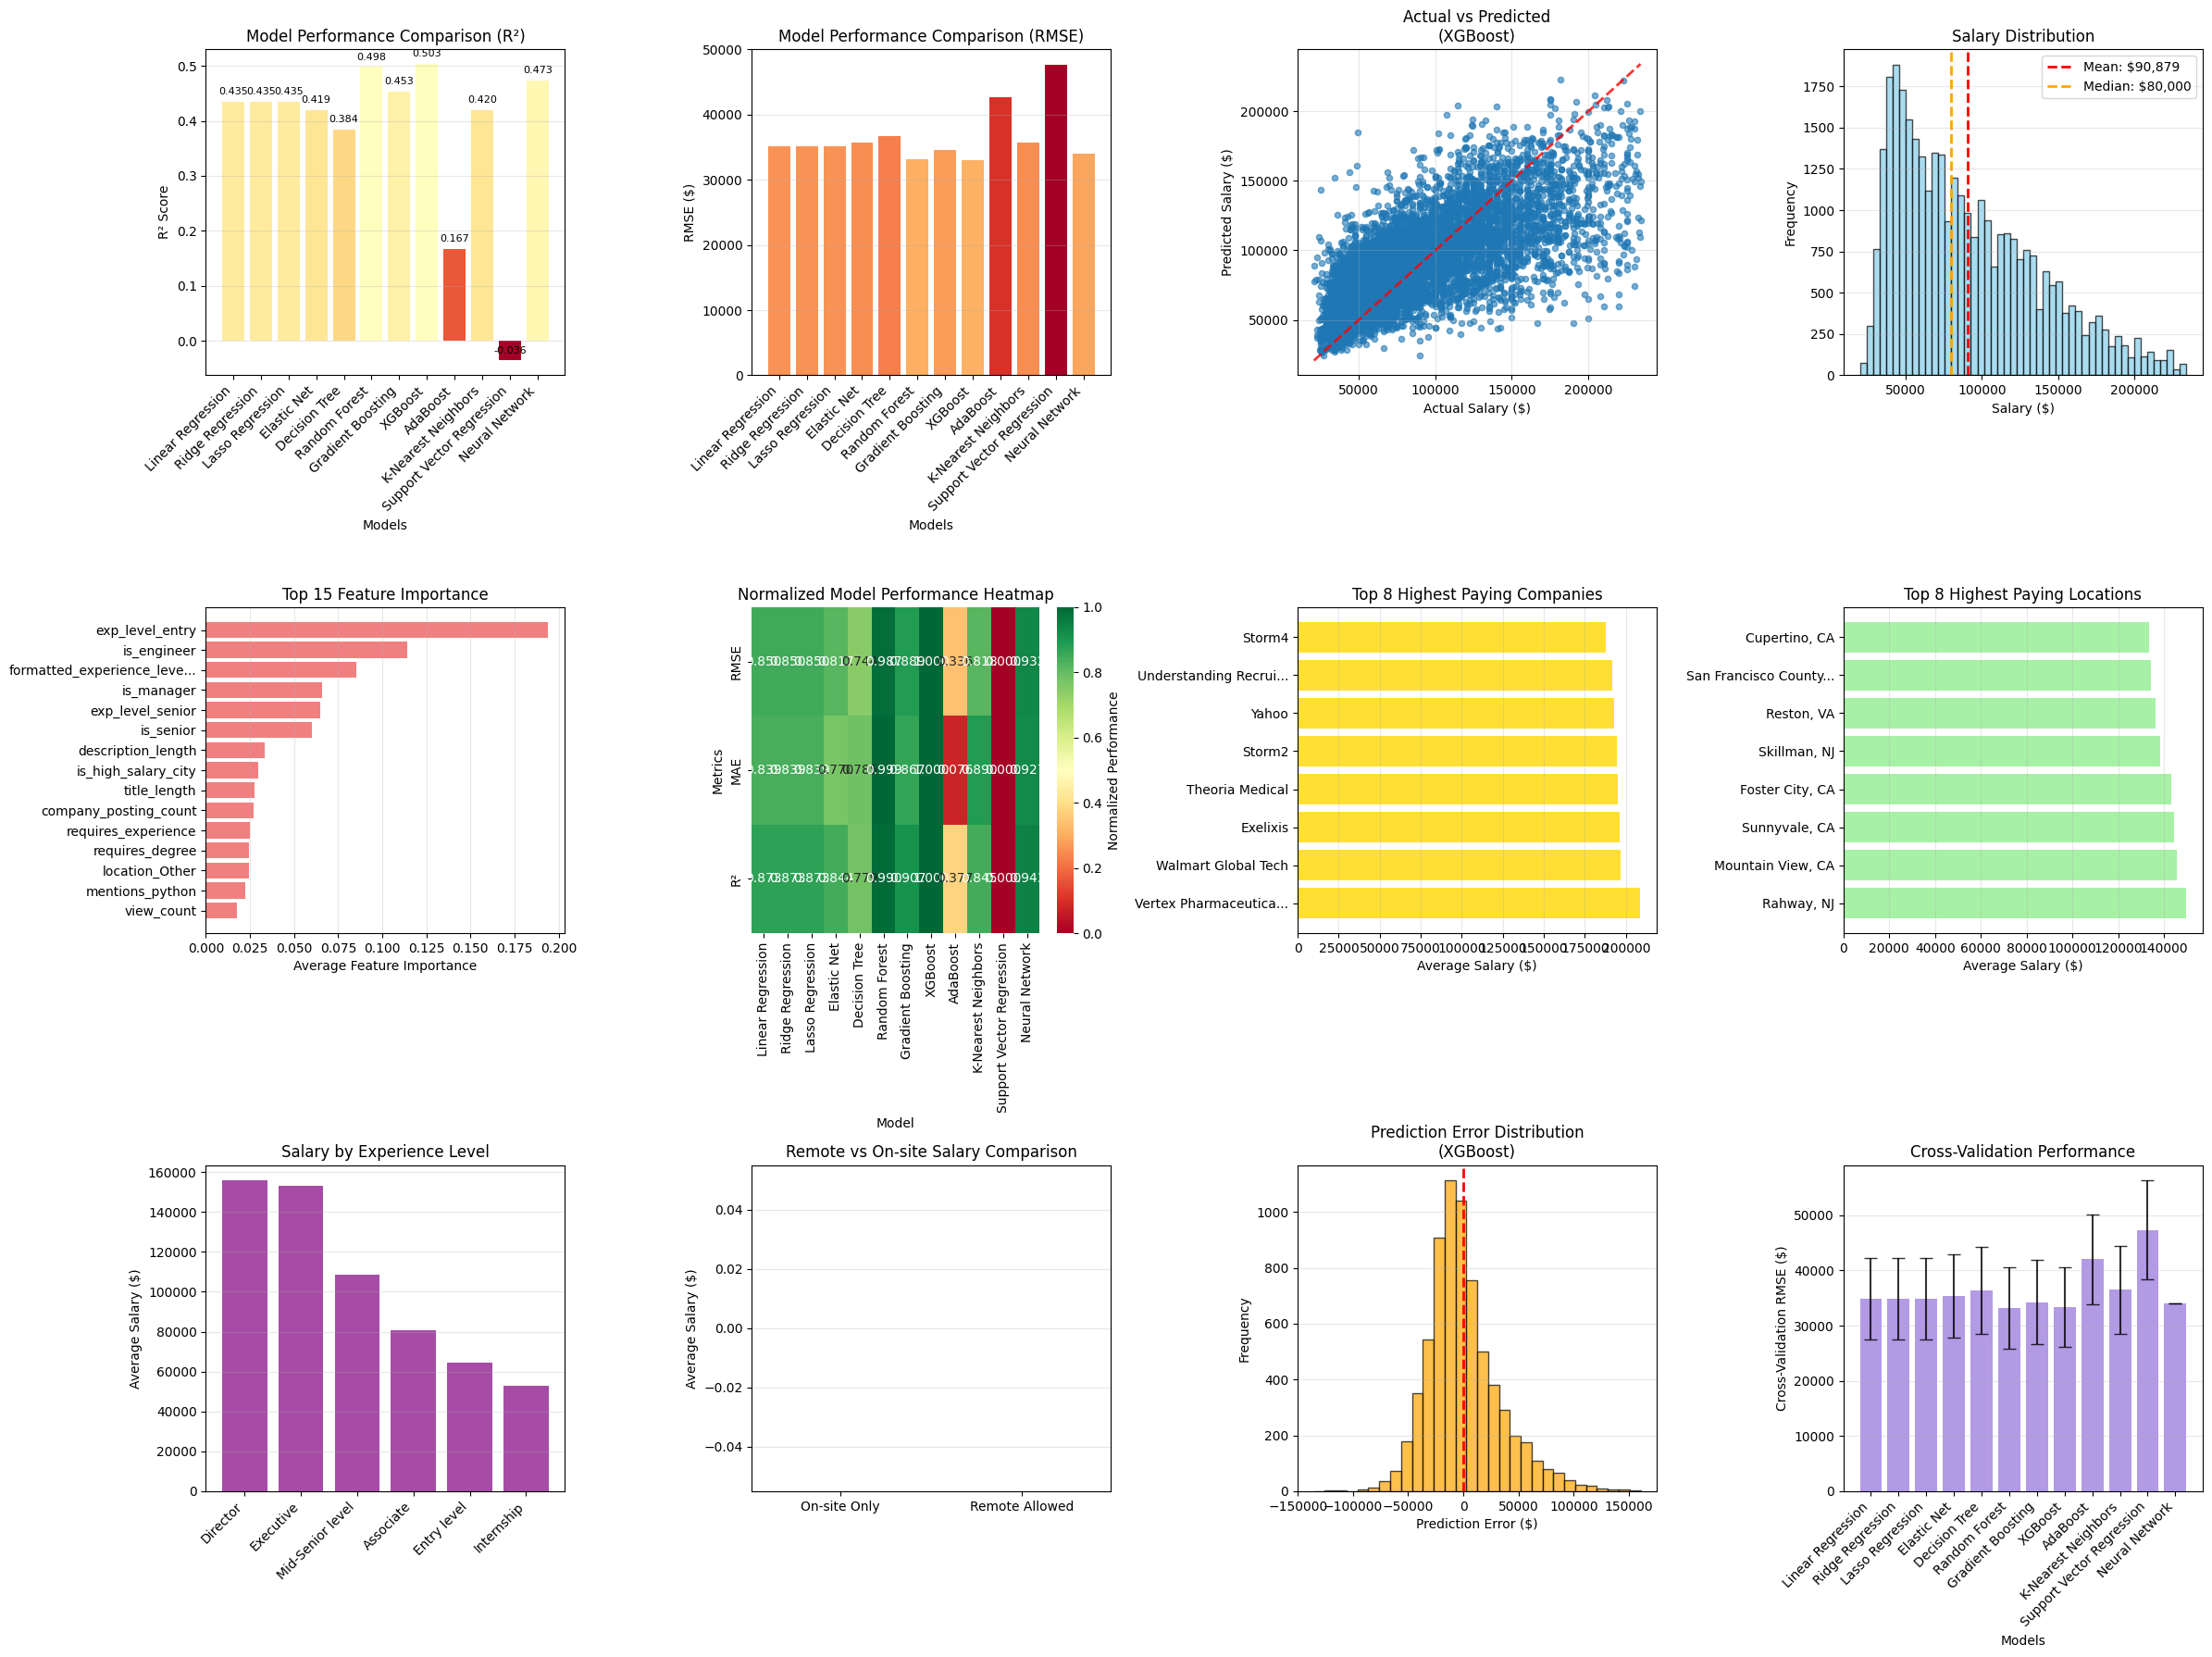


LINKEDIN JOB SALARY PREDICTION - COMPREHENSIVE RESULTS

Dataset Summary:
- Total job postings analyzed: 34,644
- Features engineered: 93
- Salary range: $20,000 - $234,000
- Mean salary: $90,879
- Median salary: $80,000
- Standard deviation: $46,495

Model Performance Ranking:
--------------------------------------------------
Rank Model                R²       RMSE         MAE          CV_RMSE   
----------------------------------------------------------------------
1    XGBoost              0.5034   $32,983      $24,718      $33,326   
2    Random Forest        0.4978   $33,169      $24,733      $33,206   
3    Neural Network       0.4729   $33,982      $25,655      $33,982   
4    Gradient Boosting    0.4534   $34,603      $26,431      $34,266   
5    Lasso Regression     0.4350   $35,182      $26,793      $34,867   
6    Ridge Regression     0.4350   $35,182      $26,793      $34,867   
7    Linear Regression    0.4350   $35,182      $26,793      $34,867   
8    K-Nearest Neighbor

In [4]:
import time
if __name__ == "__main__":
    s_t = time.time()
    predictor = LinkedInSalaryPredictor()
    file_path = "C://Users/Novin/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13/job_postings.csv"
    try:
        print("     LinkedIn Job Salary Prediction Model")
        print("     Designed for dataset with columns:")
        print("   ['job_id', 'company_name', 'title', 'description', 'max_salary',")
        print("    'pay_period', 'location', 'company_id', 'views', 'med_salary',")
        print("    'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',")
        print("    'remote_allowed', 'job_posting_url', 'application_url', 'application_type',")
        print("    'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',")
        print("    'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',")
        print("    'compensation_type', 'normalized_salary', 'zip_code', 'fips']")
        print("\n" + "="*60)
        
        df, results, tuning_results, importance_df = predictor.run_complete_analysis(df__)
        
        if df is not None:
            print("\nAnalysis completed successfully!")
            print(f"Best model achieved R² score of: {predictor.results_df['R²'].max():.4f}")
            print(f"Average prediction error: ±${predictor.results_df.loc[predictor.results_df['R²'].idxmax(), 'MAE']:,.0f}")
        else:
            print("Analysis failed. Check the error messages above.")
        
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        print("Expected file: job_postings.csv in the specified directory")
        print("Make sure the file path is correct and accessible.")
        
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        print("Please check your dataset format and try again.")
    f_t = time.time()
print("Execution Time = ", f_t-s_t)